In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
#---------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------导入相关的包---------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
def max_min_normalize2(list1):    #减最小值进行归一化
    list1=np.array(list1)
    max_value=list1.max()
    min_value=list1.min()
    list2=((list1-min_value)/(max_value-min_value))
    return list2

def AnomalyDetection4(list1,list2):    #二元独立高斯分布
    list1=np.array(list1)
    list2=np.array(list2)
    list1_mean=list1.mean()  
    list2_mean=list2.mean()
    list1_std=list1.std()
    list2_std=list2.std()
    list1_p=(((2*np.pi*list1_std**2)**0.5)**(-1))*np.exp(-1*(list1-list1_mean)**2/(2*list1_std**2))
    list2_p=(((2*np.pi*list2_std**2)**0.5)**(-1))*np.exp(-1*(list2-list2_mean)**2/(2*list2_std**2))
    list_p=list1_p*list2_p
    list_bool=(list_p>=0.001)
    list3=(list1[list_bool])
    list4=(list2[list_bool])
    return list3,list4

def delete_the_lowest_possible_point2(list1,number):  #用numpy    做z_score以3sigma原理删除边缘点
    list1=np.array(list1)
    list1_mean=list1.mean()  
    list1_std=list1.std()
    index_list=np.array(range(len(list1))).reshape(1,len(list1))
    list1_z_score=abs((np.array(list1)-list1_mean)/list1_std).reshape(1,len(list1))  #把list转换成array直接进行加减乘除操作
    list1_p=np.concatenate((index_list,list1_z_score),axis=0) #axis=1表示对应行的数组进行拼接,
    list1_p=list1_p.T[np.lexsort(list1_p)].T  #   根据数组的第二行元素进行从小到大的排序
    list2=list1_p[0][:(len(list1_p[0])-number)].astype(int)  #用切片的方式，删除了低概率的number个点，再把点的序号返回给list2
    list3=list1[list2]
    return list3

def fit(x, y):        #计算一元线性回归方程的a和b    
    x=np.array(x)
    y=np.array(y)
    x_mean = x.mean()
    y_mean= y.mean() 
    tmp_1=sum((x-x_mean)*(y-y_mean))
    tmp_2=sum((x-x_mean)**2)
    a = tmp_1 / tmp_2     # 计算a斜率的值
    b = y_mean - a * x_mean    # 计算b截距的值
    return a,b

#计算出一条经过最少点，覆盖下方所有点的上折线
def find_the_up_line2(list1,list2):      
    list3=np.unique(list1)
    list2_highest=np.array([])
    for i in list3:
        value=max(list2[np.where(list1==i)[0]])
        list2_highest=np.append(list2_highest,value)
    list1=list3
    list2=list2_highest              #排序结果输出正常

    if len(list1)<=1 or len(list2)<=1:
        return([],[])
    up_line1=[]
    up_line2=[]
    mark_point=0
    up_line1.append(list1[0])
    up_line2.append(list2[0])
    while(mark_point+1<len(list1)):
#         print(mark_point)
        list3=list1.copy()[mark_point+1:]
        list4=list2.copy()[mark_point+1:]
        list_k=(list4-list2[mark_point])/(list3-list1[mark_point])
        list_k_mark_point=np.where(list_k==max(list_k))[0][0]  #list_k中最大值的位置
        mark_point=mark_point+list_k_mark_point+1              #更新标记的位置
        up_line1.append(list1[mark_point])                 
        up_line2.append(list2[mark_point])
    return up_line1,up_line2

 #计算出一条经过最少点，兜住上方所有点的上折线
def find_the_under_line2(list1,list2):       
    list3=np.unique(list1)
    list2_highest=np.array([])
    for i in list3:
        value=min(list2[np.where(list1==i)[0]])
        list2_highest=np.append(list2_highest,value)
    list1=list3
    list2=list2_highest              #排序结果输出正常
    if len(list1)<=1 or len(list2)<=1:
        return([],[])
    under_line1=[]
    under_line2=[]
    mark_point=0
    under_line1.append(list1[0])
    under_line2.append(list2[0])
    while(mark_point+1<len(list1)):
        list3=list1.copy()[mark_point+1:]
        list4=list2.copy()[mark_point+1:]
        list_k=(list4-list2[mark_point])/(list3-list1[mark_point])
        list_k_mark_point=np.where(list_k==min(list_k))[0][0]  #list_k中最小值的位置
        mark_point=mark_point+list_k_mark_point+1              #更新标记的位置
        under_line1.append(list1[mark_point])                 
        under_line2.append(list2[mark_point])
    return under_line1,under_line2

#为消除歧义性，将点到两条回归线L1和L2的距离相加，删除最终和值最大的一群点
def delete_x_point4(list1,list2,delete_number):  
    list1=np.array(list1)
    list2=np.array(list2)
    a1,b1=fit(list1,list2)      #为消除歧义性，用交集的方式筛选出距离两条回归线都远的点
    a2,b2=fit(list2,list1)

    Y1=list1*a1+b1            #散点到线性回归线的距离
    Y2=list2*a2+b2            #交换x、y轴坐标后，散点到线性回归线的距离
    dis_list2_to_y1=np.array(abs(list2-Y1)).reshape(1,len(Y1))
    dis_list1_to_y2=np.array(abs(list1-Y2)).reshape(1,len(Y2))
    index_list=np.array(range(len(list1))).reshape(1,len(list1))
    dis_sum=dis_list2_to_y1+dis_list1_to_y2          #距离求和
    distance3=np.concatenate((index_list,dis_sum),axis=0) #axis=1表示对应行的数组进行拼接,
    distance3=distance3.T[np.lexsort(distance3)].T  #   根据数组的第二行元素进行从小到大的排序
    
    index_list=distance3[0][:len(distance3[0])-delete_number]  #用切片的方式，删除数组后面的元素

    list1=list1[index_list.astype(int)]#distance3[0].astype(int)是未删除的散点序号
    list2=list2[index_list.astype(int)]
    return(list1,list2)

 #计算得上下折线中间的面积S1或S2，与最高最低y轴线、最左最右x轴线的围成面积S的比值
def caculate_the_Square(x1,y1,x2,y2):  
    square1=np.trapz(y1,x1)
    square2=np.trapz(y2,x2)
    Original_Square=(max((x1),default=0)-min((x1),default=0))*(max((y1),default=0)-min((y2),default=0))
    Original_Square_radio=round((square1-square2)/Original_Square,4)

    return((square1-square2),Original_Square_radio,Original_Square)


#---------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------上述是前置函数-------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------

#在清理点的过程中，将散点分为三组Sc1、Sc2和Sc3，其中Sc1（近原点的点）被舍弃不做下一步使用，
#Sc2（一个坐标趋于0的点）用来计算Dsz，Sc3传播下去，做下一步分析。
#clean_data12中，times_near0_to_no00对应N，radio_y_near_zero对应Tx，radio_x_near_zero对应Ty
def clean_data12(list1,list2):     
    #清理数据中存在Nan的数据点,清理数据中存在0的数据点,记录单项为0的点的数量
    #根据单项为零的点的分布和数量，判断两个向量的相关性
    dec_sim_near_zero=0
    list1=np.array(list1)    #清理nan
    list2=np.array(list2)
    list1_bool=np.isnan(list1)
    list2_bool=np.isnan(list2)
    bool_list=np.array((list1_bool+list2_bool)==0)
    list1=list1[bool_list]
    list2=list2[bool_list]
    list1=np.around(list1, 2)
    list2=np.around(list2, 2)
    list1=max_min_normalize2(list1)  #减最小值进行归一化，范围缩放到0~1
    list2=max_min_normalize2(list2)
    list1,list2=AnomalyDetection4(list1,list2)
    lenght_list1=len(list1)     #剔除在含有Nan的维度之后，向量的长度
    if list1.size!=0 and list2.size!=0:
        list1_max=list1.max()        #这里提取最大最小值是探讨近零维度用的
        list2_max=list2.max()
        list1_min=list1.min()
        list2_min=list2.min()
    else:
        list1_max=0       #这里提取最大最小值是探讨近零维度用的
        list2_max=0
        list1_min=0
        list2_min=0
    near_x=list2_min+0.03*(list2_max-list2_min)  #立一个标准值，低于这个值视为x轴上的点
    near_y=list1_min+0.03*(list1_max-list1_min)  #立一个标准值，低于这个值视为y轴上的点
    list1_bool=(list1==0 )              #清理两个都是0的
    list2_bool=(list2==0)

    bool_list=((list1_bool.astype(int)+list2_bool.astype(int))==2)==0

    list1=list1[bool_list]
    list2=list2[bool_list]

    list1_bool=list1<=near_y          #清理单维度近0的
    list2_bool=list2<=near_x

    list_x_near_zero=list2[list1_bool]
    list_y_near_zero=list1[list2_bool]
    bool_list=(list1_bool+list2_bool)==0  #提取两个维度都不近0的
    list1=list1[bool_list]     
    list2=list2[bool_list]
   

    number_no_zero=len(list1)      #在两个向量中都非零的维度的数量
    count_near0=len(list_x_near_zero)+len(list_y_near_zero)

    if len(list1)!=0:
         times_near0_to_no0=count_near0/len(list1)
    else:
         times_near0_to_no0=13
    if len(list1)!=0 and times_near0_to_no0<13:         #所以点都接近x轴，y轴，直接判断相关性为0
        list1_max=list1.max()              #这里提取最大最小值是探讨近零维度的分布与不近零维度的分布占比用的
        list2_max=list2.max()
        list1_min=list1.min()
        list2_min=list2.min()
        if times_near0_to_no0>0.1 :

            times_near0_to_no00=int(count_near0/len(list1))

            radio_x_near_zero=0
            radio_y_near_zero=0

            if len(list_y_near_zero)>1: #list_y_near_zero向量，即落在x轴上的点（y=0）
                if len(set(list_y_near_zero))>1:
                    mark_point=int(len(list_y_near_zero)/20)+1  #少量下降点最大值的取值，希望能避开异常值。这里选择取大于95%的数
                    if mark_point==0:
                        mark_point+=1
                    list_y_near_zero=delete_the_lowest_possible_point2(list_y_near_zero.tolist(),mark_point)
                    list_y_near_zero=np.array(list_y_near_zero)
                    list_y_near_zero_max=list_y_near_zero.max()
                    list_y_near_zero_min=list_y_near_zero.min()
                    if (list1_max-list1_min)==0:
                        radio_y_near_zero=1
                    else:
                        radio_y_near_zero=(list_y_near_zero_max-list_y_near_zero_min)/(list1_max-list1_min)
                else:
                    radio_y_near_zero=0
            if len(list_x_near_zero)>1: #list_y_single_zero向量，即落在y轴上的点（x=0）

                if len(set(list_x_near_zero))>1:

                    mark_point=int(len(list_x_near_zero)/20)+1
                    if mark_point==0:
                        mark_point+=1
                    list_x_near_zero=delete_the_lowest_possible_point2(list_x_near_zero.tolist(),mark_point)

                    list_x_near_zero=np.array(list_x_near_zero)
                    list_x_near_zero_max=list_x_near_zero.max()
                    list_x_near_zero_min=list_x_near_zero.min()

                    if (list2_max-list2_min)==0:
                         radio_x_near_zero=1
                    else:
                         radio_x_near_zero=(list_x_near_zero_max-list_x_near_zero_min)/(list2_max-list2_min)

                else:
                    radio_x_near_zero=0

            if radio_x_near_zero>radio_y_near_zero:

                radio_x_near_zero=radio_x_near_zero*(1.5**times_near0_to_no00)

                dec_sim_near_zero=radio_x_near_zero*times_near0_to_no0
            else:

                radio_y_near_zero=radio_y_near_zero*(1.5**times_near0_to_no00)

                dec_sim_near_zero=radio_y_near_zero*times_near0_to_no0

        else:
            dec_sim_near_zero=0
            radio_near_zero=0  
    else:
        dec_sim_near_zero=1
    return(list1,list2,dec_sim_near_zero,lenght_list1,count_near0,number_no_zero)
#---------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------clean_data12是点分类和计算Dsz----------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
#---------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------caculate_the_regression_and_decrease_sim5是计算Dsa和Dir---------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------
#计算θL1和θL2，并根据θL1和θL2计算Dsa，函数中dec_sim对应Dsa,direction对应Dir
def caculate_the_regression_and_decrease_sim5(list1,list2,R1,R2):  
    a1,b1=fit(list1,list2)
    a2,b2=fit(list2,list1)
    a1_copy=a1      #在后面不知道哪里的机制把a更改了，所以这里做个小备份
    a2_copy=a2
    b1_copy=b1
    b2_copy=b2
    A3=0
    B3=0
    list1=np.array(list1)
    list2=np.array(list2)
              
    sum_list3=0                 #计算点在拟合的线性回归线上聚集吗
    sum_list1=sum(abs(list1))   #计算点在X轴聚集吗
    sum_list2=sum(abs(list2))   #计算点在y轴聚集吗

    if( abs(round(abs(math.atan(a1)/math.pi*180),2)-45)>abs(round(abs(math.atan(a2)/math.pi*180),2)-45)):
        A3=a1_copy
        B3=b1_copy
        sum_list3=sum(abs(list2-(A3*list1+B3)))

    else:
        A3=a2_copy
        B3=b2_copy
        sum_list3=sum(abs(list1-(A3*list2+B3)))

    if(round((math.atan(A3)/math.pi*180),2)>=0):
        direction=1
    else:
        direction=-1
    if sum_list3<sum_list1 and sum_list3<sum_list2:

        angle_to_45=round(abs(abs(math.atan(A3)/math.pi*180)-45),2)  #回归线与45度角的夹角
        if R1<=0.50 and R2 <=0.40:   #R1、R2较小的区别对待，因为矩形面积中，面积占比较小表示点分布成狭长状，目的是减小Pearson在0.7段时，diy方法的误判率
            if angle_to_45>25:       #15度开始加入dec_sim的影响，
                if angle_to_45>=35:
                    dec_sim=round((angle_to_45/45)**5,4)

                else:
                    dec_sim=round((angle_to_45/45)**(10-((angle_to_45-25)*0.5)),4)
            else:
                dec_sim=0  
        else:
            if angle_to_45>20:
                    dec_sim=round((angle_to_45/45)**3.5,4)
            else:
                dec_sim=0      
    else:
        dec_sim=1
    return dec_sim,direction
#---------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------caculate_the_regression_and_decrease_sim5是计算Dsa和Dir---------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
#diy_sim8的结果即是STgcor，其中dec_sim为Dsa，dec_sim_by_single0为Dsz
def diy_sim8(list1,list2):
    list1,list2,dec_sim_by_single0,lenght_list1,count_single0,number_no_zero=clean_data12(list1,list2) #清理含零的点，统计单零的点  
    if dec_sim_by_single0>=1:
        return 0
    x1,y1=find_the_up_line2(list1,list2)
    x2,y2=find_the_under_line2(list1,list2)
    
    if len(x1)>=2:
        if len(list1)<10:                           #根据点的数量，选定要删除的点的数量
            delete_number=1
        else:
            delete_number=int(len(list1)*0.1)
        list1,list2=delete_x_point4(list1,list2,delete_number)   #调用删除点的函数，删除指定数量点
      
        x1,y1=find_the_up_line2(list1,list2)
        x2,y2=find_the_under_line2(list1,list2)
        if len(x1)>=2:
            Square1,R1,Original_Square1=caculate_the_Square(x1,y1,x2,y2)
            R1=round(Square1/Original_Square1,4)

            list1,list2=delete_x_point4(list1,list2,delete_number)

            x1,y1=find_the_up_line2(list1,list2)
            x2,y2=find_the_under_line2(list1,list2)
            Square2,R2,Original_Square2=caculate_the_Square(x1,y1,x2,y2)

            R2=round(Square2/Original_Square1,4)

            dec_sim,direction=caculate_the_regression_and_decrease_sim5(list1,list2,R1,R2)
            if (math.isnan(R1)|math.isnan(R2)|math.isnan(dec_sim)):
                result=0
            else:

                result=1-round(R1**(2.55-int(R1*10)*0.1),2)-round(R2**(2.35-int(R2*10)*0.1),2)-round((R1-R2)**(2-(R1-R2)*3),4)-dec_sim-round(dec_sim_by_single0,2)

            if result<0:
                 result=0
            return result*direction
        else:
            return 0
    else:
         return 0       

In [5]:
adata=sc.read_visium(path=r'F:\ST dataset\10x\Visium Spatial for FFPE Demonstration (v1 Chemistry)\Human Breast Cancer Ductal Carcinoma In Situ, Invasive Carcinoma (FFPE)',count_file=r'Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000,check_values=True)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata = adata[:, adata.var.highly_variable]
data7=adata.to_df()

F:\Anaconda3\envs\python37\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
data7

,HES4,ISG15,AGRN,TNFRSF4,ANKRD65,VWA1,ATAD3C,GABRD,PRXL2B,ARHGEF16,...,IDH3G,L1CAM,EMD,ATP6AP1,PLXNA3,LAGE3,UBL4A,G6PD,DKC1,MPP1
AAACAAGTATCTCCCA-1,0.440277,0.978104,1.583496,0.440277,0.000000,1.462982,0.00000,0.0,0.440277,0.440277,...,0.978104,0.0,0.978104,2.168358,0.744920,0.440277,0.440277,0.744920,0.744920,0.440277
AAACACCAATAACTGC-1,0.000000,1.974402,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,1.636055,0.0,0.000000,1.974402,1.120842,0.000000,0.000000,1.120842,0.000000,1.974402
AAACAGAGCGACTCCT-1,1.307630,2.540715,1.029000,0.000000,0.000000,0.641398,0.00000,0.0,0.000000,0.000000,...,1.029000,0.0,1.029000,1.029000,0.000000,0.000000,0.000000,0.000000,1.029000,0.641398
AAACAGCTTTCAGAAG-1,0.000000,1.996743,1.138370,0.000000,0.000000,0.000000,0.00000,0.0,1.138370,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAACAGGGTCTATATT-1,0.000000,1.809677,1.809677,0.000000,0.000000,0.000000,1.26814,0.0,0.000000,0.000000,...,0.000000,0.0,1.268140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.268140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.856956,2.472144,0.856956,0.000000,0.000000,0.856956,0.00000,0.0,1.311559,0.856956,...,0.000000,0.0,0.000000,1.622933,0.856956,0.000000,0.000000,0.000000,0.856956,1.311559
TTGTTGTGTGTCAAGA-1,0.000000,1.497881,1.006534,0.000000,0.624896,1.675273,0.00000,0.0,0.624896,0.000000,...,1.006534,0.0,0.624896,0.624896,1.006534,0.000000,1.006534,1.497881,0.000000,0.000000
TTGTTTCACATCCAGG-1,0.000000,1.592631,2.178533,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,1.592631,0.0,0.000000,2.545531,0.000000,0.000000,0.000000,1.592631,0.000000,1.592631
TTGTTTCATTAGTCTA-1,0.897058,2.111653,1.678429,0.000000,0.000000,0.897058,0.00000,0.0,0.000000,0.000000,...,0.897058,0.0,1.362195,0.897058,0.000000,0.000000,0.000000,0.897058,0.000000,0.897058


In [8]:
list1=data7.iloc[:,0]
list2=data7.iloc[:,1]

In [10]:
no_zero_count=0
for i in range(3000):
    for j in range(i+1,3000):
        value=diy_sim8(data7.iloc[:,i],data7.iloc[:,j])
        if value>0.55:
            no_zero_count+=1
            print('diy_sim8:{},i和j分别为：{}和{}'.format(value,i,j))
        if no_zero_count>=10:
            break


diy_sim8:0.8210000000000001,i和j分别为：1和40
diy_sim8:0.5882000000000001,i和j分别为：1和99
diy_sim8:0.6765000000000001,i和j分别为：1和1383
diy_sim8:0.5577000000000001,i和j分别为：1和1586
diy_sim8:0.6999,i和j分别为：1和2086
diy_sim8:0.7016,i和j分别为：1和2473
diy_sim8:0.6844000000000001,i和j分别为：1和2591
diy_sim8:0.7156,i和j分别为：1和2813
diy_sim8:0.5823,i和j分别为：23和2927
diy_sim8:0.6099000000000001,i和j分别为：26和42
diy_sim8:0.5840000000000001,i和j分别为：98和99
diy_sim8:0.6851,i和j分别为：1115和1116
diy_sim8:0.6748,i和j分别为：1717和1718
diy_sim8:0.578,i和j分别为：2106和2107
diy_sim8:0.738,i和j分别为：2107和2108
diy_sim8:0.6688000000000001,i和j分别为：2108和2109
diy_sim8:0.6801,i和j分别为：2109和2110
diy_sim8:0.5631999999999999,i和j分别为：2351和2352
diy_sim8:0.6147,i和j分别为：2355和2356
diy_sim8:0.5811000000000001,i和j分别为：2356和2357
diy_sim8:0.6101,i和j分别为：2359和2360
diy_sim8:0.7639000000000001,i和j分别为：2633和2634


In [11]:
no_zero_count

22

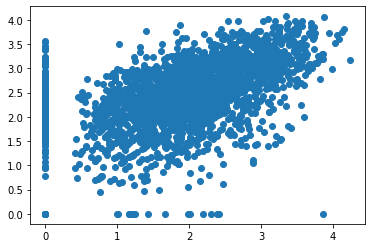

In [19]:
plt.scatter(data7.iloc[:,1],data7.iloc[:,2086])

In [13]:
no_zero_count=0
for i in range(3000):
    for j in range(i+1,3000):
        
        value=diy_sim8(data7.iloc[:,i],data7.iloc[:,j])
        if value>0.55:
            print(no_zero_count)
            no_zero_count+=1
            print('diy_sim8:{},i和j分别为：{}和{}'.format(value,i,j))
        if no_zero_count>=10:
            break


0
diy_sim8:0.8210000000000001,i和j分别为：1和40
1
diy_sim8:0.5882000000000001,i和j分别为：1和99
2
diy_sim8:0.6765000000000001,i和j分别为：1和1383
3
diy_sim8:0.5577000000000001,i和j分别为：1和1586
4
diy_sim8:0.6999,i和j分别为：1和2086
5
diy_sim8:0.7016,i和j分别为：1和2473
6
diy_sim8:0.6844000000000001,i和j分别为：1和2591
7
diy_sim8:0.7156,i和j分别为：1和2813
8
diy_sim8:0.5823,i和j分别为：23和2927
9
diy_sim8:0.6099000000000001,i和j分别为：26和42
10
diy_sim8:0.5840000000000001,i和j分别为：98和99
11
diy_sim8:0.6851,i和j分别为：1115和1116
12
diy_sim8:0.6748,i和j分别为：1717和1718
13
diy_sim8:0.578,i和j分别为：2106和2107
14
diy_sim8:0.738,i和j分别为：2107和2108
15
diy_sim8:0.6688000000000001,i和j分别为：2108和2109
16
diy_sim8:0.6801,i和j分别为：2109和2110
17
diy_sim8:0.5631999999999999,i和j分别为：2351和2352
18
diy_sim8:0.6147,i和j分别为：2355和2356
19
diy_sim8:0.5811000000000001,i和j分别为：2356和2357
20
diy_sim8:0.6101,i和j分别为：2359和2360
21
diy_sim8:0.7639000000000001,i和j分别为：2633和2634
